In [3]:
import pandas as pd
import numpy as np
import random
from faker import Faker

# Initialize Faker
fake = Faker()

# Define categories
categories = [
    "PII", "Financial Data", "Login Credentials", "Authentication Tokens",
    "Chat Messages", "Legal and Medical Text", "Business/Internal Notes"
]

# Function to generate fake data based on category
def generate_fake_data(category):
    if category == "PII":
        return random.choice([
            fake.name(),
            fake.address(),
            fake.phone_number(),
            fake.ssn(),
            fake.date_of_birth().strftime("%Y-%m-%d")
        ])
    elif category == "Financial Data":
        return random.choice([
            f"Credit Card: {fake.credit_card_number()}",
            f"Account No: {fake.bban()} at {fake.company()}",
            fake.iban(),
            f"Transaction: {fake.currency_code()} {random.uniform(1, 1000):.2f} for {fake.catch_phrase()}"
        ])
    elif category == "Login Credentials":
        return random.choice([
            f"Username: {fake.user_name()}, Password: {fake.password()}",
            f"PIN: {fake.random_number(digits=4)}"
        ])
    elif category == "Authentication Tokens":
        return random.choice([
            f"API Key: {fake.uuid4()}",
            f"Session Token: {fake.sha256()}",
            f"OAuth Token: {fake.sha1()}"
        ])
    elif category == "Chat Messages":
        return random.choice([
            fake.text(max_nb_chars=100),
            f"Hey {fake.first_name()}! {fake.sentence()} {random.choice(['😊', '👍', '😂'])}",
            f"Multilingual: {fake.sentence()} {fake.language_code()}"
        ])
    elif category == "Legal and Medical Text":
        return random.choice([
            f"Prescription: {fake.sentence()}",
            f"Legal Clause: {fake.sentence()}",
            f"Compliance: {fake.sentence()}"
        ])
    elif category == "Business/Internal Notes":
        return random.choice([
            f"Meeting Summary: {fake.sentence()}",
            f"Project Update: {fake.sentence()}",
            f"Decision: {fake.sentence()}"
        ])

# Generate synthetic dataset
def generate_synthetic_dataset(num_samples=50000):
    data = []
    for sample_id in range(1, num_samples + 1):
        category = random.choice(categories)
        original_text = generate_fake_data(category)
        plaintext_length = len(original_text)
        data.append({
            "sample_id": sample_id,
            "category": category,
            "original_text": original_text,
            "plaintext_length": plaintext_length
        })
    return pd.DataFrame(data)

# Generate a smaller sample dataset for demonstration
#sample_dataset = generate_synthetic_dataset(num_samples=50)
#sample_dataset.head()
dataset_users1=generate_synthetic_dataset(num_samples=10000)
dataset_users1.to_csv('dataset_users1.csv', index=False)

In [4]:
import pandas as pd
import numpy as np
import random
import secrets
from Crypto.Cipher import AES, DES, Blowfish, ARC4, DES3
from Crypto.Util.Padding import pad, unpad
from Crypto.PublicKey import RSA
from Crypto.Cipher import PKCS1_OAEP
from scipy.stats import entropy

# Encryption Algorithms
algorithms = ['AES', 'DES', '3DES', 'Blowfish', 'RC4', 'RSA']

# Key Lengths and Modes
key_lengths = { 'AES': [16, 24, 32], 'DES': [8], '3DES': [24], 'Blowfish': [16, 24, 32], 'RC4': [16], 'RSA': [1024, 2048] }
modes = { 'AES': [AES.MODE_CBC, AES.MODE_ECB, AES.MODE_CFB, AES.MODE_OFB, AES.MODE_GCM],
          'DES': [DES.MODE_CBC, DES.MODE_ECB], '3DES': [DES3.MODE_CBC, DES3.MODE_ECB], 'Blowfish': [Blowfish.MODE_CBC],
          'RC4': [None], 'RSA': [None] }

def generate_key(algorithm):
    """Generate a random key based on the algorithm."""
    key_length = random.choice(key_lengths[algorithm])
    key = secrets.token_bytes(key_length) if algorithm != 'RSA' else RSA.generate(key_length)
    return key, key_length

def encrypt_text(plaintext, algorithm):
    """Encrypt the given plaintext using the specified algorithm."""
    try:
        key, key_length = generate_key(algorithm)
        iv = secrets.token_bytes(16) if algorithm == 'AES' else secrets.token_bytes(8) if algorithm in ['3DES', 'Blowfish'] else None
        cipher = None
        mode = None

        if algorithm == 'AES':
            mode = random.choice(modes['AES'])
            cipher = AES.new(key, mode, iv) if mode != AES.MODE_ECB else AES.new(key, mode)
        elif algorithm == 'DES':
            mode = random.choice(modes['DES'])
            cipher = DES.new(key, mode, iv) if mode != DES.MODE_ECB else DES.new(key, mode)
        elif algorithm == '3DES':
            mode = random.choice(modes['3DES'])
            cipher = DES3.new(key, mode, iv) if mode != DES3.MODE_ECB else DES3.new(key, mode)
        elif algorithm == 'Blowfish':
            mode = random.choice(modes['Blowfish'])
            cipher = Blowfish.new(key, mode, iv)
        elif algorithm == 'RC4':
            cipher = ARC4.new(key)
        elif algorithm == 'RSA':
            cipher = PKCS1_OAEP.new(key.publickey())
            max_length = key.size_in_bytes() - 42
            if len(plaintext) > max_length:
                plaintext = plaintext[:max_length]

        if algorithm != 'RSA':
            ciphertext = cipher.encrypt(pad(plaintext.encode(), cipher.block_size))
        else:
            ciphertext = cipher.encrypt(plaintext.encode())

        return ciphertext.hex(), key_length, mode if algorithm in ['AES', 'DES', '3DES', 'Blowfish'] else None
    except Exception as e:
        print(f"Encryption error: {e}")
        return None, None, None

def calculate_stats(ciphertext):
    """Calculate length, entropy, and standard deviation of ciphertext."""
    length = len(ciphertext)
    byte_array = np.frombuffer(bytes.fromhex(ciphertext), dtype=np.uint8)
    value, counts = np.unique(byte_array, return_counts=True)
    ent = entropy(counts, base=2)
    std_dev = np.std(byte_array)
    return length, ent, std_dev

# Load the dataset from the CSV file
dataset_users1 = pd.read_csv('dataset_users1.csv')

# Encrypt each entry in the dataset
encrypted_data = []
for index, row in dataset_users1.iterrows():
    plaintext = row['original_text']
    algorithm = random.choice(algorithms)
    ciphertext, key_length, mode = encrypt_text(plaintext, algorithm)
    if ciphertext:
        length, ent, std_dev = calculate_stats(ciphertext)
        encrypted_data.append({
            "sample_id": row['sample_id'],
            "category": row['category'],
            "original_text": plaintext,
            "plaintext_length": row['plaintext_length'],
            "algorithm": algorithm,
            "ciphertext": ciphertext,
            "key_length": key_length,
            "mode": mode,
            "ciphertext_length": length,
            "entropy": ent,
            "std_dev": std_dev
        })

# Save the encrypted data to a new CSV file
encrypted_dataset = pd.DataFrame(encrypted_data)
encrypted_dataset.to_csv('encrypted_dataset_users1.csv', index=False)

print("Encrypted dataset saved to encrypted_dataset_users1.csv")


Encrypted dataset saved to encrypted_dataset_users1.csv


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
df=pd.read_csv('encrypted_dataset_users1.csv')

In [8]:
df.head

<bound method NDFrame.head of       sample_id                 category  \
0             1           Financial Data   
1             2   Legal and Medical Text   
2             3  Business/Internal Notes   
3             4  Business/Internal Notes   
4             5   Legal and Medical Text   
...         ...                      ...   
9995       9996                      PII   
9996       9997        Login Credentials   
9997       9998   Legal and Medical Text   
9998       9999        Login Credentials   
9999      10000           Financial Data   

                                          original_text  plaintext_length  \
0     Transaction: SOS 854.00 for Horizontal multi-t...                69   
1     Legal Clause: Education husband picture colleg...                72   
2      Project Update: Program cell bill product heavy.                48   
3                      Decision: Big get risk question.                32   
4      Prescription: Memory clear similar strong wrong. 

   sample_id                 category  \
0          1           Financial Data   
1          2   Legal and Medical Text   
2          3  Business/Internal Notes   
3          4  Business/Internal Notes   
4          5   Legal and Medical Text   

                                       original_text  plaintext_length  \
0  Transaction: SOS 854.00 for Horizontal multi-t...                69   
1  Legal Clause: Education husband picture colleg...                72   
2   Project Update: Program cell bill product heavy.                48   
3                   Decision: Big get risk question.                32   
4   Prescription: Memory clear similar strong wrong.                48   

  algorithm                                         ciphertext  key_length  \
0       RSA  7b4c55677e0f3e0b872f5556ef2ccd8c9cc6665a738e25...        1024   
1       RC4  702b6fde6c5d1a2ec4d6b11d0aeacdc521da44cad5245f...          16   
2      3DES  8176e09bcf6fadad6a42776c7a32a6d5a9cf797c60952e...          24

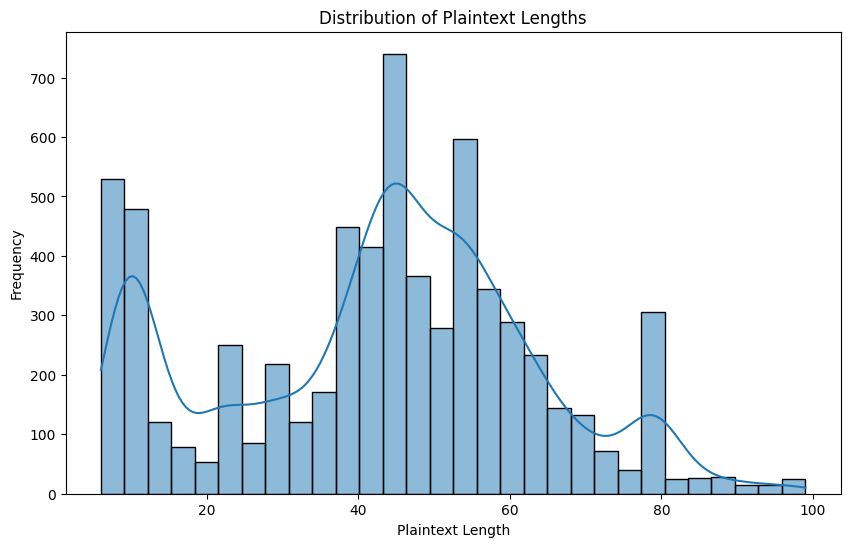

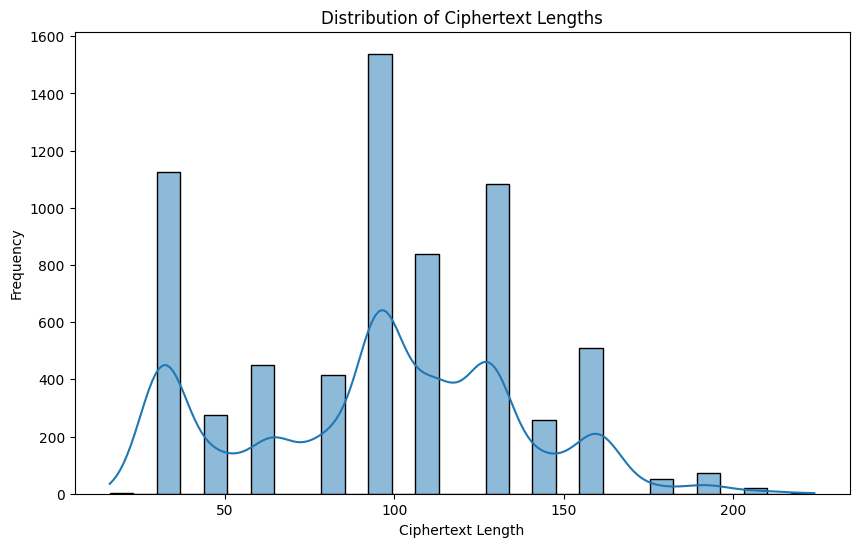

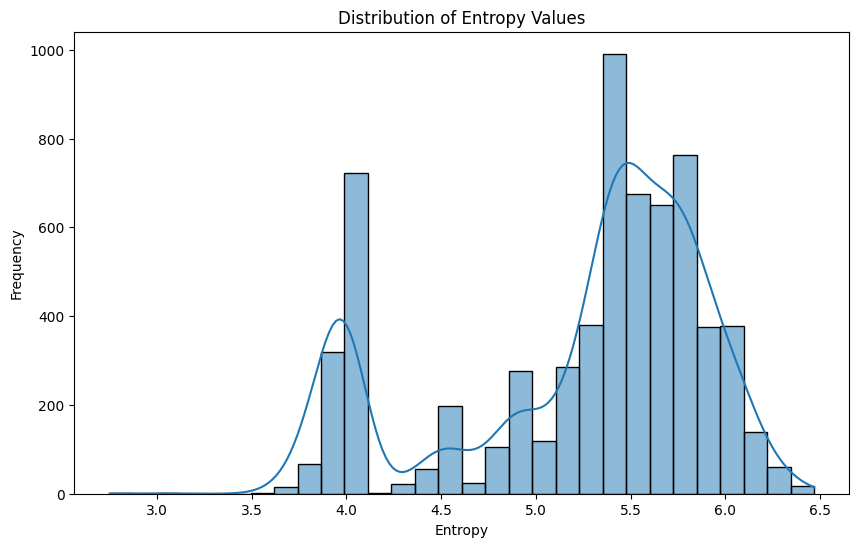

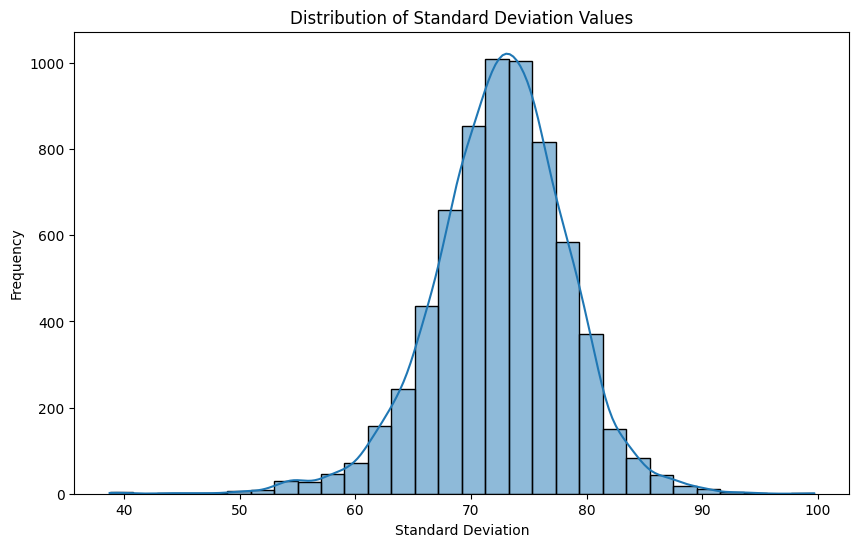

In [ ]:
# Data Exploration
print(df.head())  # Display the first few rows of the dataset
print(df.info())  # Display the dataset information
print(df.describe())  # Display the statistical summary of the dataset

# Data Cleaning
# Check for missing values
print(df.isnull().sum())

# Handle missing values (if any)
df.dropna(inplace=True)

# Check for duplicates
print(df.duplicated().sum())

# Remove duplicates (if any)
df.drop_duplicates(inplace=True)

# Data Transformation
# Example: Convert categorical variables to numerical using one-hot encoding
df = pd.get_dummies(df, columns=['category', 'algorithm', 'mode'])

# Data Analysis
# Example: Plot the distribution of plaintext lengths
plt.figure(figsize=(10, 6))
sns.histplot(df['plaintext_length'], bins=30, kde=True)
plt.title('Distribution of Plaintext Lengths')
plt.xlabel('Plaintext Length')
plt.ylabel('Frequency')
plt.show()

# Example: Plot the distribution of ciphertext lengths
plt.figure(figsize=(10, 6))
sns.histplot(df['ciphertext_length'], bins=30, kde=True)
plt.title('Distribution of Ciphertext Lengths')
plt.xlabel('Ciphertext Length')
plt.ylabel('Frequency')
plt.show()

# Example: Plot the distribution of entropy values
plt.figure(figsize=(10, 6))
sns.histplot(df['entropy'], bins=30, kde=True)
plt.title('Distribution of Entropy Values')
plt.xlabel('Entropy')
plt.ylabel('Frequency')
plt.show()

# Example: Plot the distribution of standard deviation values
plt.figure(figsize=(10, 6))
sns.histplot(df['std_dev'], bins=30, kde=True)
plt.title('Distribution of Standard Deviation Values')
plt.xlabel('Standard Deviation')
plt.ylabel('Frequency')
plt.show()


In [25]:
df.columns

Index(['sample_id', 'original_text', 'plaintext_length', 'ciphertext',
       'key_length', 'ciphertext_length', 'entropy', 'std_dev',
       'category_Authentication Tokens', 'category_Business/Internal Notes',
       'category_Chat Messages', 'category_Financial Data',
       'category_Legal and Medical Text', 'category_Login Credentials',
       'category_PII', 'mode_1.0', 'mode_2.0', 'mode_3.0', 'mode_5.0',
       'mode_11.0', 'algorithm'],
      dtype='object')

In [26]:
# # Collapse one-hot encoded algorithm columns into a single column
# algorithm_columns = ['algorithm_3DES', 'algorithm_AES', 'algorithm_Blowfish', 'algorithm_DES']

# df['algorithm'] = d[algorithm_columns].idxmax(axis=1).str.replace('algorithm_', '')

# # Optionally drop the original one-hot columns
# df.drop(columns=algorithm_columns, inplace=True)


In [27]:
df.to_csv('encrypted_dataset_users1.csv', index=False)


In [21]:
# Access the 'algorithm' column
y = df['algorithm'].values
print(y)

['3DES' '3DES' 'Blowfish' ... 'DES' 'AES' 'DES']


In [28]:
df

,sample_id,original_text,plaintext_length,ciphertext,key_length,ciphertext_length,entropy,std_dev,category_Authentication Tokens,category_Business/Internal Notes,...,category_Financial Data,category_Legal and Medical Text,category_Login Credentials,category_PII,mode_1.0,mode_2.0,mode_3.0,mode_5.0,mode_11.0,algorithm
2,3,Project Update: Program cell bill product heavy.,48,8176e09bcf6fadad6a42776c7a32a6d5a9cf797c60952e...,24,112,5.628783,66.188583,False,True,...,False,False,False,False,False,True,False,False,False,3DES
4,5,Prescription: Memory clear similar strong wrong.,48,53da0f029f3e6f52cb24cbc77f3bcf7aa7311b95bba892...,24,112,5.628783,70.530560,False,False,...,False,True,False,False,True,False,False,False,False,3DES
5,6,Legal Clause: Do military affect.,33,2dc1e2cf958c9cef7fe3af98cabfb0c749ef870b3f17bb...,16,80,5.071928,68.954872,False,False,...,False,True,False,False,False,True,False,False,False,Blowfish
6,7,Hey Melissa! Across young part data method tim...,56,ce8af02fe2eb8ccd5e96d7b77fea86edec6ca3e8f58f98...,16,128,5.906250,70.401465,False,False,...,False,False,False,False,False,False,False,False,True,AES
7,8,Decision: Final yourself anyone beat.,37,a495486f31483fa8ca1c97ee7b4c753c3888981cff08e2...,32,80,5.053056,69.814397,False,True,...,False,False,False,False,False,True,False,False,False,Blowfish
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9991,9992,OAuth Token: 044da9f90b709e05b2a4fa197a3ad1568...,53,dcf9bc5682b42a110942cd40f624a6021ab027e7c161d8...,16,112,5.628783,79.163659,True,False,...,False,False,False,False,False,True,False,False,False,Blowfish
9994,9995,Police cost turn somebody fish stuff radio. Pa...,87,a17a87f4b09fd135b521eb383bc8ed9cba56bcc5a96004...,24,176,6.169548,71.273568,False,False,...,False,False,False,False,True,False,False,False,False,3DES
9995,9996,1911-12-21,10,95cc9c6c61f3e424b59e3bf7c185721e,8,32,4.000000,66.871145,False,False,...,False,False,False,True,True,False,False,False,False,DES
9997,9998,Prescription: Yourself simple carry could.,42,01db5a8302ff61f98b3efea836dcff9917ff6195c4e2a8...,32,96,5.360902,80.258888,False,False,...,False,True,False,False,False,False,False,False,True,AES


In [33]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import joblib

# Load dataset
# df = pd.read_csv('/content/encrypted_datasetMP5000.csv')

# Drop rows with missing values (e.g., mode, if still present)
df = df.dropna()

# Select features (excluding 'mode')
features = ['ciphertext_length', 'entropy', 'std_dev', 'key_length']
X = df[features].values
y = df['algorithm'].values

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)

# Define neural network
model = Sequential([
    Dense(256, input_shape=(X_train.shape[1],), kernel_regularizer=keras.regularizers.l2(0.001)),
    BatchNormalization(),
    LeakyReLU(),
    Dropout(0.2),
    Dense(128, kernel_regularizer=keras.regularizers.l2(0.001)),
    BatchNormalization(),
    LeakyReLU(),
    Dropout(0.2),
    Dense(64, kernel_regularizer=keras.regularizers.l2(0.001)),
    BatchNormalization(),
    LeakyReLU(),
    Dropout(0.2),
    Dense(len(label_encoder.classes_), activation='softmax')
])

# Compile model
model.compile(optimizer=keras.optimizers.AdamW(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Callbacks
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1),
    EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
]

# Train model
model.fit(X_train, y_train, epochs=200, batch_size=32, validation_data=(X_test, y_test), callbacks=callbacks)

# Evaluate
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

# Save model and encoders
model.save('encryption_classifier_users.h5')
joblib.dump(scaler, 'scaler_users.pkl')
joblib.dump(label_encoder, 'label_encoder_users.pkl')

print("✅ Model and preprocessing objects saved.")


Epoch 1/200


c:\Users\jayas\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


167/167 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5122 - loss: 1.2776 - val_accuracy: 0.4251 - val_loss: 1.3417 - learning_rate: 0.0010
Epoch 2/200
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6108 - loss: 1.0166 - val_accuracy: 0.6742 - val_loss: 0.9556 - learning_rate: 0.0010
Epoch 3/200
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6325 - loss: 0.9534 - val_accuracy: 0.6689 - val_loss: 0.8534 - learning_rate: 0.0010
Epoch 4/200
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6347 - loss: 0.9070 - val_accuracy: 0.6591 - val_loss: 0.8197 - learning_rate: 0.0010
Epoch 5/200
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6397 - loss: 0.8706 - val_accuracy: 0.6591 - val_loss: 0.7911 - learning_rate: 0.0010
Epoch 6/200
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6511 - loss: 0.8138 - val_accuracy: 0.6674 - val_loss: 0.7686 - learning_rate: 0.0010
Epoch 7/200
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6593 - loss: 0.7908 - val_a

Test Accuracy: 65.84%
✅ Model and preprocessing objects saved.


In [41]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# X: your input features, y: your labels (algorithm names)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Scale numeric features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Encode labels
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

le = LabelEncoder()
y_train_encoded = to_categorical(le.fit_transform(y_train))
y_test_encoded = to_categorical(le.transform(y_test))

# Model
model = Sequential([
    #Dense(256, input_shape=(X_train_scaled.shape[1],), activation='relu'),
    #BatchNormalization(),
    #Dropout(0.3),

    #Dense(128, activation='relu'),
    #BatchNormalization(),
    #Dropout(0.3),

    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),

    Dense(y_train_encoded.shape[1], activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)

# Training
history = model.fit(
    X_train_scaled, y_train_encoded,
    validation_split=0.2,
    epochs=400,
    batch_size=64,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# Evaluation
test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test_encoded)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


Epoch 1/400
67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3530 - loss: 1.3294 - val_accuracy: 0.4403 - val_loss: 1.0288 - learning_rate: 0.0010
Epoch 2/400
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4833 - loss: 1.0058 - val_accuracy: 0.5372 - val_loss: 0.8801 - learning_rate: 0.0010
Epoch 3/400
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5204 - loss: 0.8797 - val_accuracy: 0.6199 - val_loss: 0.8031 - learning_rate: 0.0010
Epoch 4/400
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5872 - loss: 0.8118 - val_accuracy: 0.6717 - val_loss: 0.7414 - learning_rate: 0.0010
Epoch 5/400
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6468 - loss: 0.7464 - val_accuracy: 0.6773 - val_loss: 0.6963 - learning_rate: 0.0010
Epoch 6/400
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6306 - loss: 0.7248 - val_accuracy: 0.6802 - val_loss: 0.6706 - learning_rate: 0.0010
Epoch 7/400
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6475 - loss: 0.6961 - val_acc

In [55]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
import joblib

# Load model and preprocessing objects
model = load_model('encryption_classifier_users.h5')
scaler = joblib.load('scaler_users.pkl')
label_encoder = joblib.load('label_encoder_users.pkl')

# Feature extraction from ciphertext
def extract_features(ciphertext):
    byte_array = bytes.fromhex(ciphertext) if all(c in '0123456789abcdefABCDEF' for c in ciphertext) else ciphertext.encode()

    length = len(byte_array)
    entropy = -np.sum([p * np.log2(p) for p in np.bincount(np.frombuffer(byte_array, dtype=np.uint8), minlength=256) / length if p > 0])
    std_dev = np.std(np.frombuffer(byte_array, dtype=np.uint8))
    key_length = 256  # Optional: set default or estimate if unknown

    return [length, entropy, std_dev, key_length]

# Predictor
def predict_algorithm_from_ciphertext(ciphertext):
    features = extract_features(ciphertext)
    scaled = scaler.transform([features])
    prediction = model.predict(scaled)
    predicted_algorithm = label_encoder.inverse_transform([np.argmax(prediction)])[0]
    return predicted_algorithm

# Example usage
ciphertext = "d8429c9871ad412344a1e6147c3efca711734d75e604f985b25cf8006b8d8823"  # Input your ciphertext here
predicted = predict_algorithm_from_ciphertext(ciphertext)
print(f"🔐 Predicted Algorithm: {predicted}")




ciphertext = "d8429c9871ad412344a1e6147c3efca711734d75e604f985b25cf8006b8d8823"  # Input your ciphertext here
features = extract_features(ciphertext)
print(f"Extracted Features: {features}")

scaled = scaler.transform([features])
print(f"Scaled Features: {scaled}")

prediction = model.predict(scaled)
print(f"Raw Model Prediction: {prediction}")

predicted_algorithm = label_encoder.inverse_transform([np.argmax(prediction)])[0]
print(f"Predicted Algorithm: {predicted_algorithm}")
#-----------------------------------

ciphertext = "d8429c9871ad412344a1e6147c3efca711734d75e604f985b25cf8006b8d8823"  # Input your ciphertext here
features = extract_features(ciphertext)
print(f"Extracted Features: {features}")

scaled = scaler.transform([features])
print(f"Scaled Features: {scaled}")

prediction = model.predict(scaled)
print(f"Raw Model Prediction: {prediction}")

predicted_algorithm = label_encoder.inverse_transform([np.argmax(prediction)])[0]
print(f"Predicted Algorithm: {predicted_algorithm}")
#-----------------------------------
ciphertext = "8176e09bcf6fadad6a42776c7a32a6d5a9cf797c60952ed506661d225701ee5d963890c397995528af1bfa31bf3dd25609f9a6605bed748e"  # Input your ciphertext here
features = extract_features(ciphertext)
print(f"Extracted Features: {features}")

scaled = scaler.transform([features])
print(f"Scaled Features: {scaled}")

prediction = model.predict(scaled)
print(f"Raw Model Prediction: {prediction}")

predicted_algorithm = label_encoder.inverse_transform([np.argmax(prediction)])[0]
print(f"Predicted Algorithm: {predicted_algorithm}")
#-----------------------------------


ciphertext = "ac58d95bbf1703f355f95f14f180c10f5cb81c5b8a95fbfd0789c47d349ad8deb0c24d20ad3e5083b54bd798dc49f024ecbb0661e096e0c4bef693beac4e445a11430072a4fe9da0,3DES,144,6.031036112553425,75.43705985787092,1.0,24"  # Input your ciphertext here
features = extract_features(ciphertext)
print(f"Extracted Features: {features}")

scaled = scaler.transform([features])
print(f"Scaled Features: {scaled}")

prediction = model.predict(scaled)
print(f"Raw Model Prediction: {prediction}")

predicted_algorithm = label_encoder.inverse_transform([np.argmax(prediction)])[0]
print(f"Predicted Algorithm: {predicted_algorithm}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
🔐 Predicted Algorithm: AES
Extracted Features: [32, 4.875, 73.87335420121046, 256]
Scaled Features: [[-1.56424462 -0.52649307  0.22592344 28.34479786]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Raw Model Prediction: [[0.         0.67865664 0.32134333 0.        ]]
Predicted Algorithm: AES
Extracted Features: [32, 4.875, 73.87335420121046, 256]
Scaled Features: [[-1.56424462 -0.52649307  0.22592344 28.34479786]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Raw Model Prediction: [[0.         0.67865664 0.32134333 0.        ]]
Predicted Algorithm: AES
Extracted Features: [56, 5.628783493486177, 66.18858339191564, 256]
Scaled Features: [[-0.97813822  0.56177452 -1.10620393 28.34479786]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Raw Model Prediction: [[0.         0.6821867  0.31781325 0.        ]]
Predicted Algorithm: AES
Extracted Features: [196, 4.140397672519028, 22.249344247645347, 256]
Scaled Features: [[ 2.44081578 -1.58706804 -8.72291295 28.34479786]]
1/1 ━━━━━━

🔍 Label Distribution in Training Set:
AES         1338
DES         1334
3DES        1322
Blowfish    1319
Name: count, dtype: int64


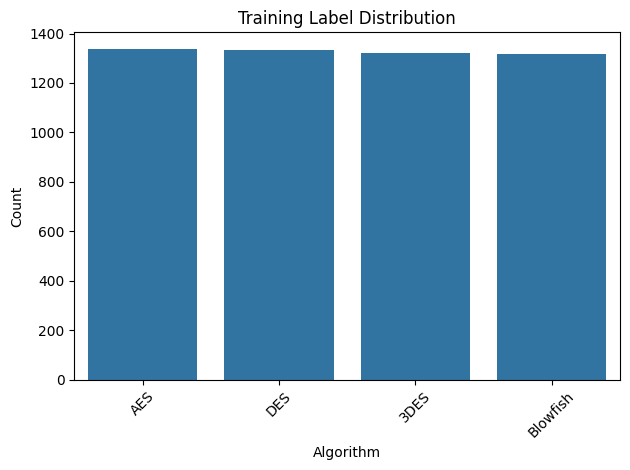

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming y_train is a pandas Series or a NumPy array of labels
label_counts = pd.Series(y_train).value_counts()

print("🔍 Label Distribution in Training Set:")
print(label_counts)

# Optional: Visualize
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.title("Training Label Distribution")
plt.xlabel("Algorithm")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

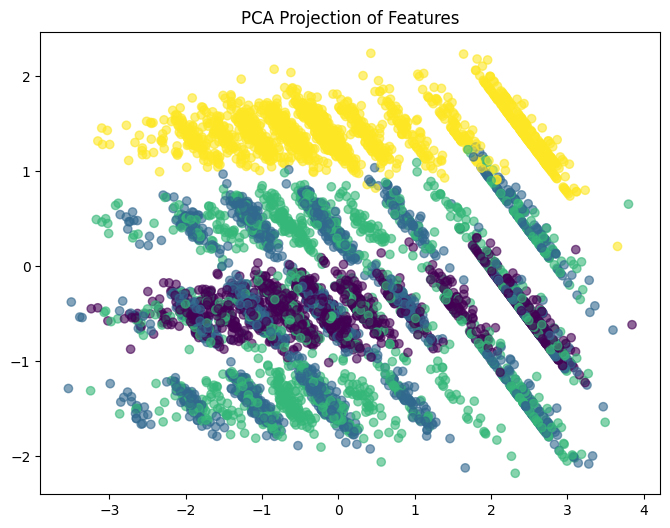

In [57]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=le.transform(y), cmap='viridis', alpha=0.6)
plt.title("PCA Projection of Features")
plt.legend(handles=scatter.legend_elements()[0], labels=le.classes_)
plt.show()


Epoch 1/200


c:\Users\jayas\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.2511 - loss: 2.2863 - val_accuracy: 0.2525 - val_loss: 1.4122 - learning_rate: 0.0010
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2332 - loss: 2.0742 - val_accuracy: 0.2500 - val_loss: 1.4131 - learning_rate: 0.0010
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2739 - loss: 1.7849 - val_accuracy: 0.2512 - val_loss: 1.4130 - learning_rate: 0.0010
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2565 - loss: 1.6882 - val_accuracy: 0.2512 - val_loss: 1.4106 - learning_rate: 0.0010
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2713 - loss: 1.5949 - val_accuracy: 0.2600 - val_loss: 1.4056 - learning_rate: 0.0010
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2821 - loss: 1.5312 - val_accuracy: 0.2463 - val_loss: 1.4067 - learning_rate: 0.0010
Epoch 7/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2660 - loss: 1.4826 - val_accuracy: 0.242

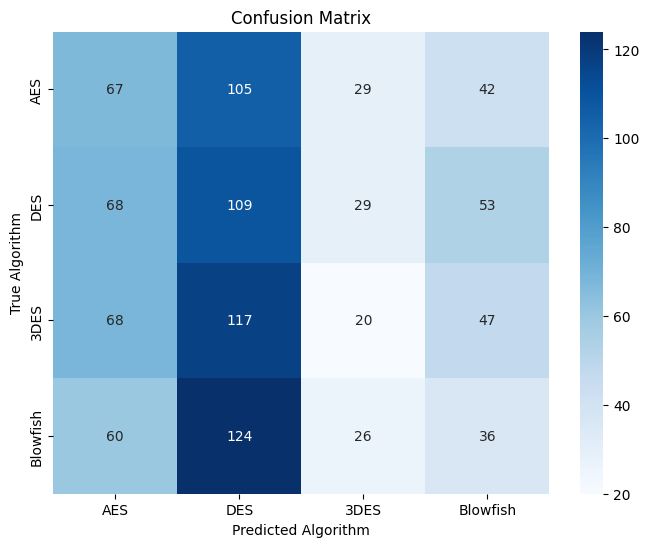

In [58]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming X and y are already loaded.
# For demonstration, let's create some dummy data
np.random.seed(42)
num_samples = 5000
num_features = 20
X = np.random.rand(num_samples, num_features)
algorithms = ['AES', 'DES', '3DES', 'Blowfish']
y = np.random.choice(algorithms, num_samples)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Scale numeric features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Encode labels
le = LabelEncoder()
y_train_encoded = to_categorical(le.fit_transform(y_train))
y_test_encoded = to_categorical(le.transform(y_test))
num_classes = y_train_encoded.shape[1]

# Model (Experimenting with a slightly different architecture)
model = Sequential([
    Dense(128, input_shape=(X_train_scaled.shape[1],), activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    Dense(num_classes, activation='softmax') # Output layer
])

# Optimizer with potentially adjusted learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001) # Keeping the initial rate for now

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True) # Increased patience
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=7) # Adjusted factor and patience

# Training
epochs = 200 # Adjusted max epochs
batch_size = 64

history = model.fit(
    X_train_scaled, y_train_encoded,
    validation_split=0.2,
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# Evaluation
test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test_encoded, verbose=0)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Detailed Classification Report
y_pred_probs = model.predict(X_test_scaled)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = le.inverse_transform(np.argmax(y_test_encoded, axis=1))
print("\nClassification Report:")
print(classification_report(y_true, le.inverse_transform(y_pred)))

# Confusion Matrix
cm = confusion_matrix(y_true, le.inverse_transform(y_pred), labels=algorithms)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=algorithms, yticklabels=algorithms)
plt.xlabel('Predicted Algorithm')
plt.ylabel('True Algorithm')
plt.title('Confusion Matrix')
plt.show()

# Optional: Analyze Feature Importance (This requires a different type of model like RandomForest)
# If your features allow for interpretation with a tree-based model, you could train one separately
# to get insights into feature importance.

Class Weights: {0: 0.9940357852882704, 1: 1.0256410256410255, 2: 1.017293997965412, 3: 0.9652509652509652}
Epoch 1/300


c:\Users\jayas\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.2595 - loss: 2.0573 - val_accuracy: 0.2288 - val_loss: 1.4153 - learning_rate: 5.0000e-04
Epoch 2/300
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2673 - loss: 1.9269 - val_accuracy: 0.2400 - val_loss: 1.4170 - learning_rate: 5.0000e-04
Epoch 3/300
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2760 - loss: 1.7637 - val_accuracy: 0.2450 - val_loss: 1.4207 - learning_rate: 5.0000e-04
Epoch 4/300
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2597 - loss: 1.7622 - val_accuracy: 0.2338 - val_loss: 1.4177 - learning_rate: 5.0000e-04
Epoch 5/300
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2693 - loss: 1.6965 - val_accuracy: 0.2338 - val_loss: 1.4178 - learning_rate: 5.0000e-04
Epoch 6/300
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2804 - loss: 1.5884 - val_accuracy: 0.2475 - val_loss: 1.4178 - learning_rate: 5.0000e-04
Epoch 7/300
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2749 - loss: 1.5

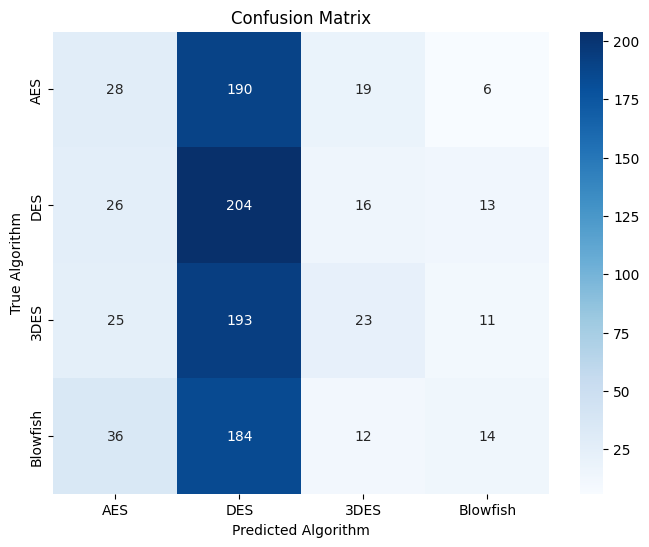

In [59]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight

# Assuming X and y are already loaded.
# For demonstration, let's create some dummy data (replace with your actual data)
np.random.seed(42)
num_samples = 5000
num_features = 20
X = np.random.rand(num_samples, num_features)
algorithms = ['AES', 'DES', '3DES', 'Blowfish']
y = np.random.choice(algorithms, num_samples)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Scale numeric features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Encode labels
le = LabelEncoder()
y_train_encoded = to_categorical(le.fit_transform(y_train))
y_test_encoded = to_categorical(le.transform(y_test))
num_classes = y_train_encoded.shape[1]

# Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(zip(le.transform(np.unique(y_train)), class_weights))
print("Class Weights:", class_weight_dict)

# Model (Experimenting with a slightly deeper architecture and adjusted dropout)
model = Sequential([
    Dense(256, input_shape=(X_train_scaled.shape[1],), activation='relu'),
    BatchNormalization(),
    Dropout(0.4),

    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(num_classes, activation='softmax') # Output layer
])

# Optimizer with a potentially different learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks (Adjusted patience and factor)
early_stop = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10)

# Training with class weights and potentially more epochs
epochs = 300
batch_size = 64

history = model.fit(
    X_train_scaled, y_train_encoded,
    validation_split=0.2,
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[early_stop, reduce_lr],
    verbose=1,
    class_weight=class_weight_dict # Applying class weights
)

# Evaluation
test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test_encoded, verbose=0)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Detailed Classification Report
y_pred_probs = model.predict(X_test_scaled)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = le.inverse_transform(np.argmax(y_test_encoded, axis=1))
print("\nClassification Report:")
print(classification_report(y_true, le.inverse_transform(y_pred)))

# Confusion Matrix
cm = confusion_matrix(y_true, le.inverse_transform(y_pred), labels=algorithms)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=algorithms, yticklabels=algorithms)
plt.xlabel('Predicted Algorithm')
plt.ylabel('True Algorithm')
plt.title('Confusion Matrix')
plt.show()

Class Weights: {0: 0.9940357852882704, 1: 1.0256410256410255, 2: 1.017293997965412, 3: 0.9652509652509652}
Epoch 1/300


c:\Users\jayas\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.2462 - loss: 2.0323 - val_accuracy: 0.2562 - val_loss: 1.4104 - learning_rate: 0.0010
Epoch 2/300
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2837 - loss: 1.6864 - val_accuracy: 0.2700 - val_loss: 1.4010 - learning_rate: 0.0010
Epoch 3/300
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2810 - loss: 1.5574 - val_accuracy: 0.2488 - val_loss: 1.4086 - learning_rate: 0.0010
Epoch 4/300
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2859 - loss: 1.5538 - val_accuracy: 0.2525 - val_loss: 1.4156 - learning_rate: 0.0010
Epoch 5/300
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2926 - loss: 1.4695 - val_accuracy: 0.2475 - val_loss: 1.4174 - learning_rate: 0.0010
Epoch 6/300
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3086 - loss: 1.4419 - val_accuracy: 0.2350 - val_loss: 1.4187 - learning_rate: 0.0010
Epoch 7/300
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3065 - loss: 1.4217 - val_accuracy: 0.24

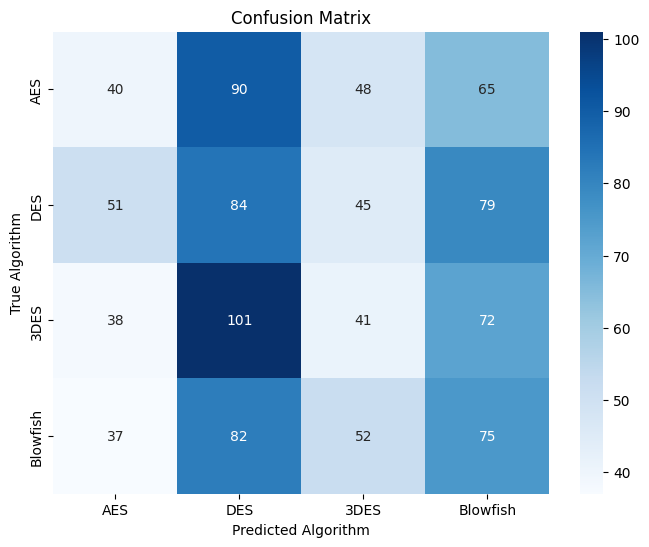

In [60]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight

# Assuming X and y are already loaded.
# For demonstration, let's create some dummy data (replace with your actual data)
np.random.seed(42)
num_samples = 5000
num_features = 20
X = np.random.rand(num_samples, num_features)
algorithms = ['AES', 'DES', '3DES', 'Blowfish']
y = np.random.choice(algorithms, num_samples)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Scale numeric features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Encode labels
le = LabelEncoder()
y_train_encoded = to_categorical(le.fit_transform(y_train))
y_test_encoded = to_categorical(le.transform(y_test))
num_classes = y_train_encoded.shape[1]

# Calculate class weights (Let's try a less aggressive approach initially)
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(zip(le.transform(np.unique(y_train)), class_weights))
print("Class Weights:", class_weight_dict)

# Model (Reverting to a slightly shallower architecture)
model = Sequential([
    Dense(128, input_shape=(X_train_scaled.shape[1],), activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(num_classes, activation='softmax') # Output layer
])

# Optimizer with a higher learning rate (Experiment)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks (Adjusted patience)
early_stop = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=8)

# Training (Keeping class weights for now, but you can comment out to test without)
epochs = 300
batch_size = 64

history = model.fit(
    X_train_scaled, y_train_encoded,
    validation_split=0.2,
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[early_stop, reduce_lr],
    verbose=1,
    class_weight=class_weight_dict # Keep or comment out to test
)

# Evaluation
test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test_encoded, verbose=0)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Detailed Classification Report
y_pred_probs = model.predict(X_test_scaled)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = le.inverse_transform(np.argmax(y_test_encoded, axis=1))
print("\nClassification Report:")
print(classification_report(y_true, le.inverse_transform(y_pred)))

# Confusion Matrix
cm = confusion_matrix(y_true, le.inverse_transform(y_pred), labels=algorithms)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=algorithms, yticklabels=algorithms)
plt.xlabel('Predicted Algorithm')
plt.ylabel('True Algorithm')
plt.title('Confusion Matrix')
plt.show()

Class Weights: {0: 0.9940357852882704, 1: 1.0256410256410255, 2: 1.017293997965412, 3: 0.9652509652509652}
Epoch 1/300


c:\Users\jayas\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.2442 - loss: 1.9712 - val_accuracy: 0.2475 - val_loss: 1.4161 - learning_rate: 8.0000e-04
Epoch 2/300
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2731 - loss: 1.6632 - val_accuracy: 0.2537 - val_loss: 1.4189 - learning_rate: 8.0000e-04
Epoch 3/300
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2837 - loss: 1.5933 - val_accuracy: 0.2663 - val_loss: 1.4232 - learning_rate: 8.0000e-04
Epoch 4/300
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2789 - loss: 1.5296 - val_accuracy: 0.2575 - val_loss: 1.4326 - learning_rate: 8.0000e-04
Epoch 5/300
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2973 - loss: 1.4863 - val_accuracy: 0.2550 - val_loss: 1.4359 - learning_rate: 8.0000e-04
Epoch 6/300
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3270 - loss: 1.4419 - val_accuracy: 0.2387 - val_loss: 1.4395 - learning_rate: 8.0000e-04
Epoch 7/300
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3235 - loss: 1.4

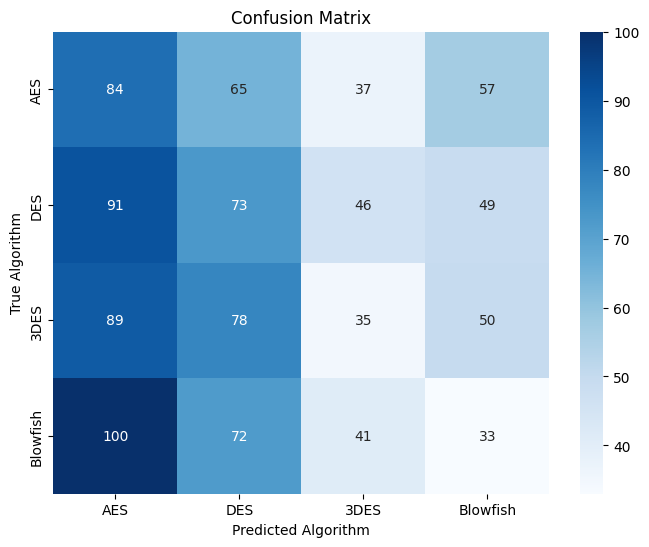

In [61]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight

# Assuming X and y are already loaded.
# For demonstration, let's create some dummy data (replace with your actual data)
np.random.seed(42)
num_samples = 5000
num_features = 20
X = np.random.rand(num_samples, num_features)
algorithms = ['AES', 'DES', '3DES', 'Blowfish']
y = np.random.choice(algorithms, num_samples)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Scale numeric features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Encode labels
le = LabelEncoder()
y_train_encoded = to_categorical(le.fit_transform(y_train))
y_test_encoded = to_categorical(le.transform(y_test))
num_classes = y_train_encoded.shape[1]

# Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(zip(le.transform(np.unique(y_train)), class_weights))
print("Class Weights:", class_weight_dict)

# Model (Trying a slightly different dropout configuration)
model = Sequential([
    Dense(128, input_shape=(X_train_scaled.shape[1],), activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    Dense(num_classes, activation='softmax') # Output layer
])

# Optimizer with a slightly lower learning rate (Experiment)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0008)

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks (Adjusted patience)
early_stop = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10)

# Training
epochs = 300
batch_size = 64

history = model.fit(
    X_train_scaled, y_train_encoded,
    validation_split=0.2,
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[early_stop, reduce_lr],
    verbose=1,
    class_weight=class_weight_dict
)

# Evaluation
test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test_encoded, verbose=0)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Detailed Classification Report
y_pred_probs = model.predict(X_test_scaled)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = le.inverse_transform(np.argmax(y_test_encoded, axis=1))
print("\nClassification Report:")
print(classification_report(y_true, le.inverse_transform(y_pred)))

# Confusion Matrix
cm = confusion_matrix(y_true, le.inverse_transform(y_pred), labels=algorithms)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=algorithms, yticklabels=algorithms)
plt.xlabel('Predicted Algorithm')
plt.ylabel('True Algorithm')
plt.title('Confusion Matrix')
plt.show()

Class Weights: {0: 0.9940357852882704, 1: 1.0256410256410255, 2: 1.017293997965412, 3: 0.9652509652509652}
Epoch 1/300


c:\Users\jayas\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.2412 - loss: 2.2082 - val_accuracy: 0.2450 - val_loss: 1.4231 - learning_rate: 5.0000e-04
Epoch 2/300
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2630 - loss: 1.9057 - val_accuracy: 0.2350 - val_loss: 1.4359 - learning_rate: 5.0000e-04
Epoch 3/300
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2696 - loss: 1.7789 - val_accuracy: 0.2362 - val_loss: 1.4474 - learning_rate: 5.0000e-04
Epoch 4/300
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2807 - loss: 1.7344 - val_accuracy: 0.2325 - val_loss: 1.4536 - learning_rate: 5.0000e-04
Epoch 5/300
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2695 - loss: 1.6626 - val_accuracy: 0.2188 - val_loss: 1.4572 - learning_rate: 5.0000e-04
Epoch 6/300
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2819 - loss: 1.6130 - val_accuracy: 0.2350 - val_loss: 1.4611 - learning_rate: 5.0000e-04
Epoch 7/300
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2890 - loss: 1.5

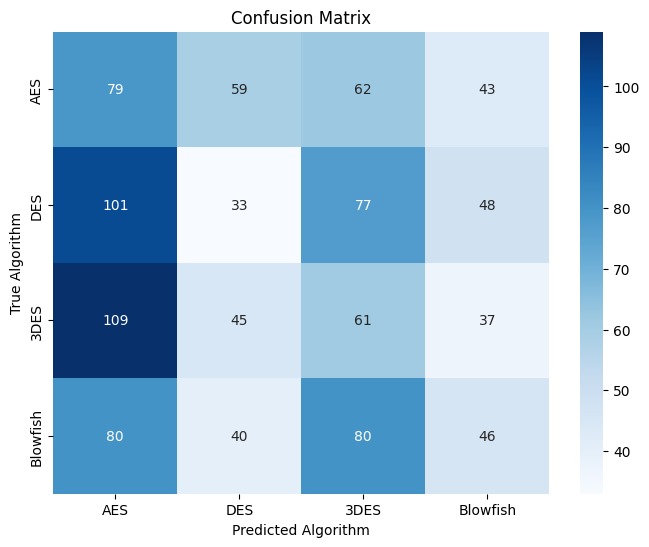

In [62]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight

# Assuming X and y are already loaded.
# For demonstration, let's create some dummy data (replace with your actual data)
np.random.seed(42)
num_samples = 5000
num_features = 20
X = np.random.rand(num_samples, num_features)
algorithms = ['AES', 'DES', '3DES', 'Blowfish']
y = np.random.choice(algorithms, num_samples)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Scale numeric features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Encode labels
le = LabelEncoder()
y_train_encoded = to_categorical(le.fit_transform(y_train))
y_test_encoded = to_categorical(le.transform(y_test))
num_classes = y_train_encoded.shape[1]

# Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(zip(le.transform(np.unique(y_train)), class_weights))
print("Class Weights:", class_weight_dict)

# Model (Adjusting dropout)
model = Sequential([
    Dense(128, input_shape=(X_train_scaled.shape[1],), activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(num_classes, activation='softmax') # Output layer
])

# Optimizer with a lower learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks (Adjusted patience)
early_stop = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10)

# Training
epochs = 300
batch_size = 64

history = model.fit(
    X_train_scaled, y_train_encoded,
    validation_split=0.2,
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[early_stop, reduce_lr],
    verbose=1,
    class_weight=class_weight_dict
)

# Evaluation
test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test_encoded, verbose=0)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Detailed Classification Report
y_pred_probs = model.predict(X_test_scaled)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = le.inverse_transform(np.argmax(y_test_encoded, axis=1))
print("\nClassification Report:")
print(classification_report(y_true, le.inverse_transform(y_pred)))

# Confusion Matrix
cm = confusion_matrix(y_true, le.inverse_transform(y_pred), labels=algorithms)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=algorithms, yticklabels=algorithms)
plt.xlabel('Predicted Algorithm')
plt.ylabel('True Algorithm')
plt.title('Confusion Matrix')
plt.show()

Class Weights: {0: 0.9940357852882704, 1: 1.0256410256410255, 2: 1.017293997965412, 3: 0.9652509652509652}
Epoch 1/300


c:\Users\jayas\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.2533 - loss: 1.9504 - val_accuracy: 0.2375 - val_loss: 1.4785 - learning_rate: 5.0000e-04
Epoch 2/300
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2683 - loss: 1.6435 - val_accuracy: 0.2350 - val_loss: 1.4944 - learning_rate: 5.0000e-04
Epoch 3/300
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2736 - loss: 1.5738 - val_accuracy: 0.2412 - val_loss: 1.4792 - learning_rate: 5.0000e-04
Epoch 4/300
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2935 - loss: 1.5091 - val_accuracy: 0.2375 - val_loss: 1.4647 - learning_rate: 5.0000e-04
Epoch 5/300
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2910 - loss: 1.4599 - val_accuracy: 0.2375 - val_loss: 1.4565 - learning_rate: 5.0000e-04
Epoch 6/300
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3089 - loss: 1.4394 - val_accuracy: 0.2412 - val_loss: 1.4477 - learning_rate: 5.0000e-04
Epoch 7/300
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.279

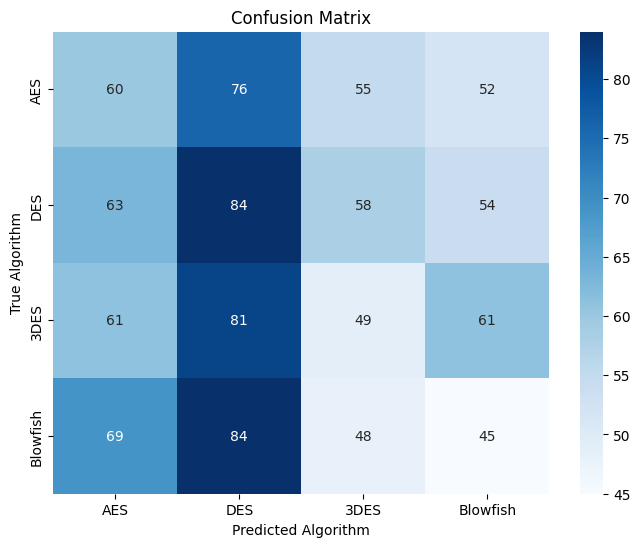

In [65]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight

# Assuming X and y are already loaded.
# For demonstration, let's create some dummy data (replace with your actual data)
np.random.seed(42)
num_samples = 5000
num_features = 20
X = np.random.rand(num_samples, num_features)
algorithms = ['AES', 'DES', '3DES', 'Blowfish']
y = np.random.choice(algorithms, num_samples)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Scale numeric features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Encode labels
le = LabelEncoder()
y_train_encoded = to_categorical(le.fit_transform(y_train))
y_test_encoded = to_categorical(le.transform(y_test))
num_classes = y_train_encoded.shape[1]

# Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(zip(le.transform(np.unique(y_train)), class_weights))
print("Class Weights:", class_weight_dict)

# Model (Adjusting dropout)
model = Sequential([
    Dense(128, input_shape=(X_train_scaled.shape[1],), activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(num_classes, activation='softmax') # Output layer
])

# Optimizer with a lower learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks (Adjusted patience)
early_stop = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10)

# Training
epochs = 300
batch_size = 16
history = model.fit(
    X_train_scaled, y_train_encoded,
    validation_split=0.2,
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[early_stop, reduce_lr],
    verbose=1,
    class_weight=class_weight_dict
)

# Evaluation
test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test_encoded, verbose=0)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Detailed Classification Report
y_pred_probs = model.predict(X_test_scaled)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = le.inverse_transform(np.argmax(y_test_encoded, axis=1))
print("\nClassification Report:")
print(classification_report(y_true, le.inverse_transform(y_pred)))

# Confusion Matrix
cm = confusion_matrix(y_true, le.inverse_transform(y_pred), labels=algorithms)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=algorithms, yticklabels=algorithms)
plt.xlabel('Predicted Algorithm')
plt.ylabel('True Algorithm')
plt.title('Confusion Matrix')
plt.show()